# Colorectal histology dataset with LeNet 5

# Preview: Neural Network examples with `tf.keras`

- `tf.keras` Software (http://keras.io/);

- Visual example of LeNet-5 (http://yann.lecun.com/exdb/lenet/) using MNIST digits dataset;

- Examples with common neural network topologies (https://machinelearningmastery.com/tensorflow-tutorial-deep-learning-with-tf-keras/).

## Colorectal histology

Methods to diagnose colorectal using histology images (<https://zenodo.org/record/53169#.XGZemKwzbmG>, <https://www.tensorflow.org/datasets/catalog/colorectal_histology>)

In this case, the purpose is to classify the type of histology in a given image in the following categories:

- 0: TUMOR
- 1: STROMA
- 2: COMPLEX
- 3: LYMPHO
- 4: DEBRIS
- 5: MUCOSA
- 6: ADIPOSE
- 7: EMPTY

## Local instalation (option 1)

Install the following Python packages to run this notebook

`pip install pip -U`

`pip install tensorflow jupyter`

## Google Colab (option 2)

[Google Colab](https://colab.research.google.com/) is a research project created to help disseminate machine learning education and research. It's a `Jupyter notebook` environment that requires no setup to use and runs entirely in the cloud.

Colaboratory notebooks are stored in [Google Drive](https://drive.google.com) and can be shared just as you would with Google Docs or Sheets. Colaboratory is free to use.

For more information, see our [FAQ](https://research.google.com/colaboratory/faq.html).

### How install extra packages
Google Colab installs a series of basic packages if we need any additional package just install it.

In [ ]:
!pip install -q keras sklearn

## Import packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import collections

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics

import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import keras
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img, ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

from scipy.stats import wilcoxon
import warnings
warnings.filterwarnings('ignore')


## Define global constants

Lets start with a few epochs to test learning network parameters

In [2]:
#Function to set the number of epochs and batches
def set_epochs_batches(epochs_number , batches ): 
  epochs= epochs_number
  batch_size = batches
  return 

In [3]:
batch_size = 32 #Number of training examples
nb_classes = 8  #or 8
epochs = 5 #Number of iterations // Passes the entire training has completed
# Scaling input image to theses dimensions
img_rows, img_cols = 32, 32

## Load image database

In [4]:
def format_example(image):
    image = tf.cast(image, tf.float32)
    # Normalize the pixel values
    image = image / 255.0
    # Resize the image
    image = tf.image.resize(image, (img_rows, img_cols))
    return image


def load_data(name="colorectal_histology"):
  train_ds = tfds.load(name, split=tfds.Split.TRAIN, batch_size=-1)
  train_ds['image'] = tf.map_fn(format_example, train_ds['image'], dtype=tf.float32)
  numpy_ds = tfds.as_numpy(train_ds)
  X, y = numpy_ds['image'], numpy_ds['label']

  return np.array(X), np.array(y)

## Plot images

In [5]:
def plot_symbols(X,y,n=15):
    index = np.random.randint(len(y), size=n)
    plt.figure(figsize=(25, 2))
    for i in np.arange(n):
        ax = plt.subplot(1,n,i+1)
        plt.imshow(X[index[i],:,:,:])
        plt.gray()
        ax.set_title(f'{y[index[i]]}-{index[i]}')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

## Build LeNet5 structure

<center><img src="https://www.dlsi.ua.es/~juanra/UA/curso_verano_DL/images/LeNet5.jpg"></center>

In [6]:
#
# Build an ANN structure - LeNet5
#
# The model will receive the activation functions
def cnn_model(activation_functions):
    #
    # Neural Network Structure
    #
    
    model = Sequential()
    
    
    model.add(layers.Conv2D(6, (5, 5))) #Output dimensionality, kernel_size (Height, width)
    model.add(layers.Activation(activation_functions[0])) #Applies an activation function to an output
    model.add(layers.MaxPooling2D(pool_size=(2, 2))) #Getting a size 2x2 for the window
    
    model.add(layers.Conv2D(16, (5, 5)))
    model.add(layers.Activation(activation_functions[1]))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
        
    model.add(layers.Flatten())
    
    model.add(layers.Dense(120)) #dense(Dimensionality of the output space)
    model.add(layers.Activation(activation_functions[2]))
    
    model.add(layers.Dense(84))
    model.add(layers.Activation(activation_functions[3]))
    
    model.add(layers.Dense(nb_classes))
    model.add(layers.Activation(activation_functions[4]))

    return model

## Start to run the program

### Load data

In [7]:
##################################################################################
# Main program

X, y = load_data()
print("Los resultados que hemos obtenido, son los siguientes")

print(X.shape, 'train samples')
print(img_rows,'x', img_cols, 'image size')
print(epochs,'epochs')

Shuffling and writing examples to /root/tensorflow_datasets/colorectal_histology/2.0.0.incomplete7CXW7E/colorectal_histology-train.tfrecord


Dataset colorectal_histology downloaded and prepared to /root/tensorflow_datasets/colorectal_histology/2.0.0. Subsequent calls will reuse this data.
Los resultados que hemos obtenido, son los siguientes
(5000, 32, 32, 3) train samples
32 x 32 image size
5 epochs


Only for binary classification. All number of classes greater than 0 will be set to 1.

In [8]:
if nb_classes==2:
  y[y>0] = 1

### Let to see examples of the dataset

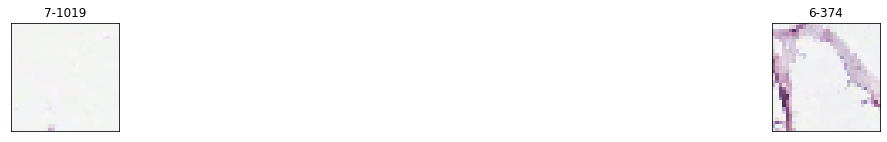

In [9]:
plot_symbols(X, y, 2)

## Number of examples per class

In [10]:
collections.Counter(y)

Counter({0: 625, 1: 625, 2: 625, 3: 625, 4: 625, 5: 625, 6: 625, 7: 625})

## Split examples in training/test sets

#Fucntion to create some models with different epochs in order to compare each other and get the best one

In [11]:
import time
#Primero, cambiaremos las funciones de activación
activation_functions = []
activation_functions.append(["tanh", "tanh", "tanh", "tanh", "softmax"] )
activation_functions.append(["sigmoid", "sigmoid" , "sigmoid", "sigmoid" , "softmax"])
activation_functions.append( ["relu", "relu", "relu", "relu", "softmax"])
activation_functions.append( ["tanh", "tanh", "tanh", "tanh", "relu"])
activation_functions.append( ["sigmoid", "sigmoid", "sigmoid", "sigmoid", "relu"])
activation_functions.append( ["relu", "relu", "relu", "relu", "relu"])
optimizers = ['adam' , 'sgd' , 'adadelta'] 
augmentation = [True, False]
best = 0
best_optimizer = ''
with_data_augmentation = False
best_function = []
best_epoch_number = 0
best_batch_number = 0

In [12]:
def get_best_optimizer(data_augmentation): 
  optimizers = ['adam' , 'sgd' , 'adadelta'] 
  best_acc = 0
  best_auc=0
  best_optimizer = ''
  with_data_augmentation = True
  best_function = ["relu", "relu", "relu", "relu", "softmax"]
  best_epoch_number = 0
  best_batch_number = 0
  set_epochs_batches(8,32 ) #Probamos cuál es el mejor modelo con las mismas épocas y batches
  best_epoch = 8
  best_batch_number= 32
  last_acc_percent_per_fold= []
  last_auc_percent_per_fold=[]
  for optimizer_i in optimizers:
    epochs = 8
    batch_size = 32
    #set_epochs_batches(epoch_i , batch_i ) 
    print("The new size is " , str(epochs) , ", " , batch_size)
    #Getting the result
    acc_per_fold, loss_per_fold, auc_per_fold, acc_percent_per_fold, auc_percent_per_fold, model = cross_validation(10 , best_function , optimizer_i , True , 32 , 8)
    plt.plot(range(len( auc_percent_per_fold)) , auc_percent_per_fold , label=best_function[0] + ", " +  best_function[4] + " [ " + str(8) + ", " + str(32) + ", " + str(optimizer_i) + ", " + str(True)  +" ]")
    #Getting the media_value
    total_acc = 0
    total_auc = 0
    for i in range(len(acc_per_fold)): 
      total_acc = total_acc + acc_per_fold[i]
      total_auc = total_auc + auc_per_fold[i]

    media_value_acc = total_acc/len(acc_per_fold)
    media_value_auc = total_auc/len(auc_per_fold)
    print("The media value acc is  " , media_value_acc , "And the value auc is " , media_value_auc , "And the activation optimizer is " , optimizer_i)
    if media_value_acc > best_acc and media_value_auc > best_auc: 
      if len(last_acc_percent_per_fold)>0: 
        wilcox_v_acc, p_val_acc = wilcoxon(acc_percent_per_fold , last_acc_percent_per_fold)  
        wilcox_v_auc, p_val_auc = wilcoxon(auc_percent_per_fold, last_auc_percent_per_fold)
        if p_val_acc<0.05 and p_val_auc < 0.05: #Rechazamos la hipótesis nula
          last_acc_percent_per_fold = acc_percent_per_fold
          last_auc_percent_per_fold = auc_percent_per_fold
          best_acc = media_value_acc
          best_auc = media_value_auc
          best_epoch_number = 8
          best_batch_number = 32
          best_optimizer =optimizer_i
      else: 
        last_acc_percent_per_fold = acc_percent_per_fold
        last_auc_percent_per_fold = auc_percent_per_fold
        best_acc = media_value_acc
        best_auc = media_value_auc
        best_epoch_number = 8
        best_batch_number = 32
        best_optimizer =optimizer_i

    
  print("AND WITH THE OPTIMIZER " + best_optimizer)
  print("THE BEST MODEL IS " , best_function )
  print("WITH A EPOCH_NUMBER OF " , best_epoch_number , " AND A BATCH SIZE OF " , best_batch_number )
  print("BEST MEDIA AUC " ,best_auc)
  print("BEST MEDIA ACC " , best_acc)
  print("AND WITH DATA_AUGMENTATION "  , with_data_augmentation )
  print("FIRST MODEL GRAPHIC")
  plt.ylabel('Aciertos')
  plt.xlabel('Fold')
  plt.legend()
  return

In [19]:
def get_best_epoch(data_augmentation , optimizer_i ):
  best_acc = 0
  best_auc=0
  best_optimizer = ''
  with_data_augmentation = True
  best_function = ["tanh", "tanh", "tanh", "tanh", "softmax"]
  best_epoch_number = 0
  best_batch_number = 0
  set_epochs_batches(8,32 ) #Probamos cuál es el mejor modelo con las mismas épocas y batches
  best_epoch = 8
  best_batch_number= 32
  last_acc_percent_per_fold= []
  last_auc_percent_per_fold=[]
  for epoch_i  in range(5,12): 
    epochs = epoch_i
    batch_size = 32
    #set_epochs_batches(epoch_i , batch_i ) 
    print("The new size is " , str(epochs) , ", " , batch_size)
    #Getting the result
    acc_per_fold, loss_per_fold, auc_per_fold, acc_percent_per_fold, auc_percent_per_fold, model = cross_validation(10 , best_function , 'adam' , True , 32 , epoch_i)
    plt.plot(range(len( auc_percent_per_fold)) , auc_percent_per_fold , label=best_function[0] + ", " +  best_function[4] + " [ " + str(epoch_i) + ", " + str(32) + ", " + str(optimizer_i) + ", " + str(True)  +" ]")
     #Getting the media_value
    total_acc = 0
    total_auc = 0
    for i in range(len(acc_per_fold)): 
      total_acc = total_acc + acc_per_fold[i]
      total_auc = total_auc + auc_per_fold[i]

    media_value_acc = total_acc/len(acc_per_fold)
    media_value_auc = total_auc/len(auc_per_fold)
    print("The media value acc is  " , media_value_acc , "And the value auc is " , media_value_auc , "And the activation epoch is " , epoch_i)
    if media_value_acc > best_acc and media_value_auc > best_auc: 
      if len(last_acc_percent_per_fold)>0: 
        wilcox_v_acc, p_val_acc = wilcoxon(acc_percent_per_fold , last_acc_percent_per_fold)  
        wilcox_v_auc, p_val_auc = wilcoxon(auc_percent_per_fold, last_auc_percent_per_fold)
        print("VALUES ACC " , wilcox_v_acc , p_val_acc )
        print("VALUES AUC ", wilcox_v_auc, p_val_auc)
        if p_val_acc<0.05 and p_val_auc < 0.05: #Rechazamos la hipótesis nula
          last_acc_percent_per_fold = acc_percent_per_fold
          last_auc_percent_per_fold = auc_percent_per_fold
          best_acc = media_value_acc
          best_auc = media_value_auc
          best_epoch_number = epoch_i
          best_batch_number = 32
          best_optimizer ='adam'
      else: 
        
        last_acc_percent_per_fold = acc_percent_per_fold
        last_auc_percent_per_fold = auc_percent_per_fold
        best_acc = media_value_acc
        best_auc = media_value_auc
        best_epoch_number = epoch_i
        best_batch_number = 32
        best_optimizer =optimizer_i

    
  print("AND WITH THE OPTIMIZER " + best_optimizer)
  print("THE BEST MODEL IS " , best_function )
  print("WITH A EPOCH_NUMBER OF " , best_epoch_number , " AND A BATCH SIZE OF " , best_batch_number )
  print("BEST MEDIA AUC " ,best_auc)
  print("BEST MEDIA ACC " , best_acc)
  print("AND WITH DATA_AUGMENTATION "  , with_data_augmentation )
  print("FIRST MODEL GRAPHIC")
  plt.ylabel('Aciertos')
  plt.xlabel('Fold')
  plt.legend()
  return

In [14]:

def get_best_activation_function(data_augmentation):
  activation_functions = []
  activation_functions.append(["sigmoid", "sigmoid" , "sigmoid", "sigmoid" , "softmax"])
  activation_functions.append( ["relu", "relu", "relu", "relu", "softmax"])
  activation_functions.append(["tanh", "tanh", "tanh", "tanh", "softmax"] )
  
  
  best_acc = 0
  best_auc=0
  best_optimizer = ''
  with_data_augmentation = True
  best_function = ["tanh", "tanh", "tanh", "tanh", "softmax"]
  best_epoch_number = 0
  best_batch_number = 0
  set_epochs_batches(8,32 ) #Probamos cuál es el mejor modelo con las mismas épocas y batches
  best_epoch = 8
  best_batch_number= 32
  last_acc_percent_per_fold= []
  last_auc_percent_per_fold=[]
 
  #Pondremos el optimizador de adam
  for activation_function in activation_functions: 
    acc_per_fold, loss_per_fold, auc_per_fold, acc_percent_per_fold, auc_percent_per_fold, model = cross_validation(10 , activation_function , "adam" , data_augmentation , 32,8)
    print("Sacando la gráfica del modelo")
    plt.plot(range(len( auc_percent_per_fold)) , auc_percent_per_fold , label=str(activation_function[0]) + ", " +  activation_function[4] )
    #Getting the media_value
    total_acc = 0
    total_auc = 0
    for i in range(len(acc_per_fold)): 
      total_acc = total_acc + acc_per_fold[i]
      total_auc = total_auc + auc_per_fold[i]

    media_value_acc = total_acc/len(acc_per_fold)
    
    media_value_auc = total_auc/len(auc_per_fold)
    print("The media value acc is  " , media_value_acc , "And the value auc is " , media_value_auc , "And the activation function is " , activation_function)
    if media_value_acc > best_acc and media_value_auc > best_auc: 
      if len(last_acc_percent_per_fold)>0: 
        wilcox_v_acc, p_val_acc = wilcoxon(acc_percent_per_fold , last_acc_percent_per_fold)  
        wilcox_v_auc, p_val_auc = wilcoxon(auc_percent_per_fold, last_auc_percent_per_fold)
        if p_val_acc<0.05 and p_val_auc < 0.05: #Rechazamos la hipótesis nula
          last_acc_percent_per_fold = acc_percent_per_fold
          last_auc_percent_per_fold = auc_percent_per_fold
          best_function = activation_function
          best_acc = media_value_acc
          best_auc = media_value_auc
          best_epoch_number = 8
          best_batch_number = 32
          best_optimizer ='adam'
      else: 
        last_acc_percent_per_fold = acc_percent_per_fold
        last_auc_percent_per_fold = auc_percent_per_fold
        best_function = activation_function
        best_acc = media_value_acc
        best_auc = media_value_auc
        best_epoch_number = 8
        best_batch_number = 32
        best_optimizer ='adam'

    
  print("AND WITH THE OPTIMIZER " + best_optimizer)
  print("THE BEST MODEL IS " , best_function )
  print("WITH A EPOCH_NUMBER OF " , best_epoch_number , " AND A BATCH SIZE OF " , best_batch_number )
  print("BEST MEDIA AUC " ,best_auc)
  print("BEST MEDIA ACC " , best_acc)
  print("AND WITH DATA_AUGMENTATION "  , with_data_augmentation )
  print("FIRST MODEL GRAPHIC")
  plt.ylabel('Aciertos')
  plt.xlabel('Fold')
  plt.legend()
  return

Before  4500
Getting the len of the arrays  563   563
The old size was  563
The shape is  (4500, 32, 32, 3)
[1 1 1 ... 1 1 1]
The shape is  (5063, 32, 32, 3)
[0 0 0 ... 1 1 1]
The shape is  (5626, 32, 32, 3)
[0 0 0 ... 1 1 1]
The shape is  (6189, 32, 32, 3)
[0 0 0 ... 1 1 1]
The shape is  (6752, 32, 32, 3)
[0 0 0 ... 1 1 1]
The new size is  3378
Y TRAIN [0 0 0 ... 1 1 1]
After  3378
X_train (7315, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7315,) y_test (500,)
y_train_nn (7315, 2) y_test_nn (500, 2)
The batch and the epoch are   32 ,  8
206/206 - 1s - loss: 0.2077 - accuracy: 0.9111 - val_loss: 0.3554 - val_accuracy: 0.8566
16/16 [==============================] - 0s 3ms/step - loss: 0.2821 - accuracy: 0.8820
loss: 0.28 acc: 0.88
Predictions Counter({1: 497, 0: 3}) 

Confusion matrix
[[  3  59]
 [  0 438]] 

              precision    recall  f1-score   support

       TUMOR       1.00      0.05      0.09        62
     HEALTHY       0.88      1.00      0.94       438

    accuracy   

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The new size is  3378
Y TRAIN [0 0 0 ... 1 1 1]
After  3378
X_train (7315, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7315,) y_test (500,)
y_train_nn (7315, 2) y_test_nn (500, 2)
The batch and the epoch are   32 ,  8
206/206 - 1s - loss: 0.2294 - accuracy: 0.9054 - val_loss: 0.3288 - val_accuracy: 0.8552
16/16 [==============================] - 0s 2ms/step - loss: 0.2784 - accuracy: 0.8820
loss: 0.28 acc: 0.88
Predictions Counter({1: 495, 0: 5}) 

Confusion matrix
[[  4  58]
 [  1 437]] 

              precision    recall  f1-score   support

       TUMOR       0.80      0.06      0.12        62
     HEALTHY       0.88      1.00      0.94       438

    accuracy                           0.88       500
   macro avg       0.84      0.53      0.53       500
weighted avg       0.87      0.88      0.84       500

AUC 0.8823 
Before  4500
Getting the len of the arrays  563   563
The old size was  563
The shape is  (4500, 32, 32, 3)
[1 1 1 ... 1 1 1]
The shape is  (5063, 32, 32, 3)
[0 0 0 .

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The new size is  3378
Y TRAIN [0 0 0 ... 1 1 1]
After  3378
X_train (7315, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7315,) y_test (500,)
y_train_nn (7315, 2) y_test_nn (500, 2)
The batch and the epoch are   32 ,  8
206/206 - 1s - loss: 7.5461 - accuracy: 0.4313 - val_loss: 1.4313 - val_accuracy: 0.7473
16/16 [==============================] - 0s 2ms/step - loss: 1.1927 - accuracy: 0.7180
loss: 1.19 acc: 0.72
Predictions Counter({1: 371, 0: 129}) 

Confusion matrix
[[ 25  37]
 [104 334]] 

              precision    recall  f1-score   support

       TUMOR       0.19      0.40      0.26        62
     HEALTHY       0.90      0.76      0.83       438

    accuracy                           0.72       500
   macro avg       0.55      0.58      0.54       500
weighted avg       0.81      0.72      0.76       500

AUC 0.6497 
Before  4500
Getting the len of the arrays  563   563
The old size was  563
The shape is  (4500, 32, 32, 3)
[1 1 1 ... 1 1 1]
The shape is  (5063, 32, 32, 3)
[0 0 0

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


206/206 - 1s - loss: 1.1465 - accuracy: 0.6992 - val_loss: 0.4331 - val_accuracy: 0.8456
16/16 [==============================] - 0s 2ms/step - loss: 0.3930 - accuracy: 0.8740
loss: 0.39 acc: 0.87
Predictions Counter({1: 499, 0: 1}) 

Confusion matrix
[[  0  62]
 [  1 437]] 

              precision    recall  f1-score   support

       TUMOR       0.00      0.00      0.00        62
     HEALTHY       0.88      1.00      0.93       438

    accuracy                           0.87       500
   macro avg       0.44      0.50      0.47       500
weighted avg       0.77      0.87      0.82       500

AUC 0.6672 
Before  4500
Getting the len of the arrays  562   562
The old size was  562
The shape is  (4500, 32, 32, 3)
[1 1 1 ... 1 1 1]
The shape is  (5062, 32, 32, 3)
[0 0 0 ... 1 1 1]
The shape is  (5624, 32, 32, 3)
[0 0 0 ... 1 1 1]
The shape is  (6186, 32, 32, 3)
[0 0 0 ... 1 1 1]
The shape is  (6748, 32, 32, 3)
[0 0 0 ... 1 1 1]
The shape is  (7310, 32, 32, 3)
[0 0 0 ... 1 1 1]
The new 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The new size is  3934
Y TRAIN [0 0 0 ... 1 1 1]
After  3934
X_train (7872, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7872,) y_test (500,)
y_train_nn (7872, 2) y_test_nn (500, 2)
The batch and the epoch are   32 ,  8
222/222 - 1s - loss: 1.1921e-07 - accuracy: 0.5394 - val_loss: 1.1921e-07 - val_accuracy: 0.1434
16/16 [==============================] - 0s 2ms/step - loss: 1.1921e-07 - accuracy: 0.1260
loss: 0.00 acc: 0.13
Predictions Counter({0: 500}) 

Confusion matrix
[[ 63   0]
 [437   0]] 

              precision    recall  f1-score   support

       TUMOR       0.13      1.00      0.22        63
     HEALTHY       0.00      0.00      0.00       437

    accuracy                           0.13       500
   macro avg       0.06      0.50      0.11       500
weighted avg       0.02      0.13      0.03       500

AUC 0.5000 
Before  4500
Getting the len of the arrays  562   562
The old size was  562
The shape is  (4500, 32, 32, 3)
[1 1 1 ... 1 1 1]
The shape is  (5062, 32, 32, 3)
[0

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The new size is  3934
Y TRAIN [0 0 0 ... 1 1 1]
After  3934
X_train (7872, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7872,) y_test (500,)
y_train_nn (7872, 2) y_test_nn (500, 2)
The batch and the epoch are   32 ,  8
222/222 - 1s - loss: 8.6940 - accuracy: 0.4606 - val_loss: 2.3114 - val_accuracy: 0.8566
16/16 [==============================] - 0s 2ms/step - loss: 2.0309 - accuracy: 0.8740
loss: 2.03 acc: 0.87
Predictions Counter({1: 500}) 

Confusion matrix
[[  0  63]
 [  0 437]] 

              precision    recall  f1-score   support

       TUMOR       0.00      0.00      0.00        63
     HEALTHY       0.87      1.00      0.93       437

    accuracy                           0.87       500
   macro avg       0.44      0.50      0.47       500
weighted avg       0.76      0.87      0.82       500

AUC 0.7726 
Before  4500
Getting the len of the arrays  562   562
The old size was  562
The shape is  (4500, 32, 32, 3)
[1 1 1 ... 1 1 1]
The shape is  (5062, 32, 32, 3)
[0 0 0 ... 1 1

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The new size is  3934
Y TRAIN [0 0 0 ... 1 1 1]
After  3934
X_train (7872, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7872,) y_test (500,)
y_train_nn (7872, 2) y_test_nn (500, 2)
The batch and the epoch are   32 ,  8
222/222 - 1s - loss: 0.2880 - accuracy: 0.8618 - val_loss: 0.3445 - val_accuracy: 0.5470
16/16 [==============================] - 0s 2ms/step - loss: 0.3091 - accuracy: 0.5640
loss: 0.31 acc: 0.56
Predictions Counter({1: 341, 0: 159}) 

Confusion matrix
[[  2  61]
 [157 280]] 

              precision    recall  f1-score   support

       TUMOR       0.01      0.03      0.02        63
     HEALTHY       0.82      0.64      0.72       437

    accuracy                           0.56       500
   macro avg       0.42      0.34      0.37       500
weighted avg       0.72      0.56      0.63       500

AUC 0.2614 
Before  4500
Getting the len of the arrays  562   562
The old size was  562
The shape is  (4500, 32, 32, 3)
[1 1 1 ... 0 0 0]
The shape is  (5062, 32, 32, 3)
[0 0 0

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The new size is  3378
Y TRAIN [0 0 0 ... 1 1 1]
After  3378
X_train (7315, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7315,) y_test (500,)
y_train_nn (7315, 2) y_test_nn (500, 2)
The batch and the epoch are   32 ,  8
206/206 - 1s - loss: 8.1141 - accuracy: 0.4966 - val_loss: 13.7180 - val_accuracy: 0.1489
16/16 [==============================] - 0s 2ms/step - loss: 14.1195 - accuracy: 0.1240
loss: 14.12 acc: 0.12
Predictions Counter({0: 500}) 

Confusion matrix
[[ 62   0]
 [438   0]] 

              precision    recall  f1-score   support

       TUMOR       0.12      1.00      0.22        62
     HEALTHY       0.00      0.00      0.00       438

    accuracy                           0.12       500
   macro avg       0.06      0.50      0.11       500
weighted avg       0.02      0.12      0.03       500

AUC 0.5000 
Before  4500
Getting the len of the arrays  563   563
The old size was  563
The shape is  (4500, 32, 32, 3)
[1 1 1 ... 1 1 1]
The shape is  (5063, 32, 32, 3)
[0 0 0 ... 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


206/206 - 1s - loss: 1.1921e-07 - accuracy: 0.4966 - val_loss: 1.1921e-07 - val_accuracy: 0.1489
16/16 [==============================] - 0s 2ms/step - loss: 1.1921e-07 - accuracy: 0.1240
loss: 0.00 acc: 0.12
Predictions Counter({0: 500}) 

Confusion matrix
[[ 62   0]
 [438   0]] 

              precision    recall  f1-score   support

       TUMOR       0.12      1.00      0.22        62
     HEALTHY       0.00      0.00      0.00       438

    accuracy                           0.12       500
   macro avg       0.06      0.50      0.11       500
weighted avg       0.02      0.12      0.03       500

AUC 0.5000 
Before  4500
Getting the len of the arrays  563   563
The old size was  563
The shape is  (4500, 32, 32, 3)
[1 1 1 ... 1 1 1]
The shape is  (5063, 32, 32, 3)
[0 0 0 ... 1 1 1]
The shape is  (5626, 32, 32, 3)
[0 0 0 ... 1 1 1]
The shape is  (6189, 32, 32, 3)
[0 0 0 ... 1 1 1]
The shape is  (6752, 32, 32, 3)
[0 0 0 ... 1 1 1]
The new size is  3378
Y TRAIN [0 0 0 ... 1 1 1]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


After  3378
X_train (7315, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7315,) y_test (500,)
y_train_nn (7315, 2) y_test_nn (500, 2)
The batch and the epoch are   32 ,  8
206/206 - 1s - loss: 1.1921e-07 - accuracy: 0.4966 - val_loss: 1.1921e-07 - val_accuracy: 0.1489
16/16 [==============================] - 0s 2ms/step - loss: 1.1921e-07 - accuracy: 0.1240
loss: 0.00 acc: 0.12
Predictions Counter({0: 500}) 

Confusion matrix
[[ 62   0]
 [438   0]] 

              precision    recall  f1-score   support

       TUMOR       0.12      1.00      0.22        62
     HEALTHY       0.00      0.00      0.00       438

    accuracy                           0.12       500
   macro avg       0.06      0.50      0.11       500
weighted avg       0.02      0.12      0.03       500

AUC 0.5000 
Before  4500
Getting the len of the arrays  563   563
The old size was  563
The shape is  (4500, 32, 32, 3)
[1 1 1 ... 1 1 1]
The shape is  (5063, 32, 32, 3)
[0 0 0 ... 1 1 1]
The shape is  (5626, 32, 32, 3)


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


After  3378
X_train (7315, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7315,) y_test (500,)
y_train_nn (7315, 2) y_test_nn (500, 2)
The batch and the epoch are   32 ,  8
206/206 - 1s - loss: 8.1141 - accuracy: 0.4966 - val_loss: 13.7180 - val_accuracy: 0.1489
16/16 [==============================] - 0s 2ms/step - loss: 14.1195 - accuracy: 0.1240
loss: 14.12 acc: 0.12
Predictions Counter({0: 500}) 

Confusion matrix
[[ 62   0]
 [438   0]] 

              precision    recall  f1-score   support

       TUMOR       0.12      1.00      0.22        62
     HEALTHY       0.00      0.00      0.00       438

    accuracy                           0.12       500
   macro avg       0.06      0.50      0.11       500
weighted avg       0.02      0.12      0.03       500

AUC 0.5000 
Before  4500
Getting the len of the arrays  563   563
The old size was  563
The shape is  (4500, 32, 32, 3)
[1 1 1 ... 1 1 1]
The shape is  (5063, 32, 32, 3)
[0 0 0 ... 1 1 1]
The shape is  (5626, 32, 32, 3)
[0 0 0 ..

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


After  3378
X_train (7315, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7315,) y_test (500,)
y_train_nn (7315, 2) y_test_nn (500, 2)
The batch and the epoch are   32 ,  8
206/206 - 1s - loss: 3.8777 - accuracy: 0.5340 - val_loss: 13.7180 - val_accuracy: 0.1489
16/16 [==============================] - 0s 2ms/step - loss: 14.1195 - accuracy: 0.1240
loss: 14.12 acc: 0.12
Predictions Counter({0: 500}) 

Confusion matrix
[[ 62   0]
 [438   0]] 

              precision    recall  f1-score   support

       TUMOR       0.12      1.00      0.22        62
     HEALTHY       0.00      0.00      0.00       438

    accuracy                           0.12       500
   macro avg       0.06      0.50      0.11       500
weighted avg       0.02      0.12      0.03       500

AUC 0.5000 
Before  4500
Getting the len of the arrays  562   562
The old size was  562
The shape is  (4500, 32, 32, 3)
[1 1 1 ... 1 1 1]
The shape is  (5062, 32, 32, 3)
[0 0 0 ... 1 1 1]
The shape is  (5624, 32, 32, 3)
[0 0 0 ..

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The new size is  3934
Y TRAIN [0 0 0 ... 1 1 1]
After  3934
X_train (7872, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7872,) y_test (500,)
y_train_nn (7872, 2) y_test_nn (500, 2)
The batch and the epoch are   32 ,  8
222/222 - 1s - loss: 1.1921e-07 - accuracy: 0.5394 - val_loss: 1.1921e-07 - val_accuracy: 0.1434
16/16 [==============================] - 0s 2ms/step - loss: 1.1921e-07 - accuracy: 0.1260
loss: 0.00 acc: 0.13
Predictions Counter({0: 500}) 

Confusion matrix
[[ 63   0]
 [437   0]] 

              precision    recall  f1-score   support

       TUMOR       0.13      1.00      0.22        63
     HEALTHY       0.00      0.00      0.00       437

    accuracy                           0.13       500
   macro avg       0.06      0.50      0.11       500
weighted avg       0.02      0.13      0.03       500

AUC 0.5000 
Before  4500
Getting the len of the arrays  562   562
The old size was  562
The shape is  (4500, 32, 32, 3)
[1 1 1 ... 1 1 1]
The shape is  (5062, 32, 32, 3)
[0

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The new size is  3934
Y TRAIN [0 0 0 ... 1 1 1]
After  3934
X_train (7872, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7872,) y_test (500,)
y_train_nn (7872, 2) y_test_nn (500, 2)
The batch and the epoch are   32 ,  8
222/222 - 1s - loss: 7.4242 - accuracy: 0.5394 - val_loss: 13.8067 - val_accuracy: 0.1434
16/16 [==============================] - 0s 2ms/step - loss: 14.0872 - accuracy: 0.1260
loss: 14.09 acc: 0.13
Predictions Counter({0: 500}) 

Confusion matrix
[[ 63   0]
 [437   0]] 

              precision    recall  f1-score   support

       TUMOR       0.13      1.00      0.22        63
     HEALTHY       0.00      0.00      0.00       437

    accuracy                           0.13       500
   macro avg       0.06      0.50      0.11       500
weighted avg       0.02      0.13      0.03       500

AUC 0.5000 
Before  4500
Getting the len of the arrays  562   562
The old size was  562
The shape is  (4500, 32, 32, 3)
[1 1 1 ... 1 1 1]
The shape is  (5062, 32, 32, 3)
[0 0 0 ... 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The new size is  3934
Y TRAIN [0 0 0 ... 1 1 1]
After  3934
X_train (7872, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7872,) y_test (500,)
y_train_nn (7872, 2) y_test_nn (500, 2)
The batch and the epoch are   32 ,  8
222/222 - 1s - loss: 8.6938 - accuracy: 0.4606 - val_loss: 2.3114 - val_accuracy: 0.8566
16/16 [==============================] - 0s 2ms/step - loss: 2.0309 - accuracy: 0.8740
loss: 2.03 acc: 0.87
Predictions Counter({1: 500}) 

Confusion matrix
[[  0  63]
 [  0 437]] 

              precision    recall  f1-score   support

       TUMOR       0.00      0.00      0.00        63
     HEALTHY       0.87      1.00      0.93       437

    accuracy                           0.87       500
   macro avg       0.44      0.50      0.47       500
weighted avg       0.76      0.87      0.82       500

AUC 0.5000 
Before  4500
Getting the len of the arrays  562   562
The old size was  562
The shape is  (4500, 32, 32, 3)
[1 1 1 ... 1 1 1]
The shape is  (5062, 32, 32, 3)
[0 0 0 ... 1 1

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The new size is  3934
Y TRAIN [0 0 0 ... 1 1 1]
After  3934
X_train (7872, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7872,) y_test (500,)
y_train_nn (7872, 2) y_test_nn (500, 2)
The batch and the epoch are   32 ,  8
222/222 - 1s - loss: 0.6308 - accuracy: 0.6276 - val_loss: 0.7641 - val_accuracy: 0.4023
16/16 [==============================] - 0s 2ms/step - loss: 0.7729 - accuracy: 0.3780
loss: 0.77 acc: 0.38
Predictions Counter({0: 374, 1: 126}) 

Confusion matrix
[[ 63   0]
 [311 126]] 

              precision    recall  f1-score   support

       TUMOR       0.17      1.00      0.29        63
     HEALTHY       1.00      0.29      0.45       437

    accuracy                           0.38       500
   macro avg       0.58      0.64      0.37       500
weighted avg       0.90      0.38      0.43       500

AUC 0.6291 
Before  4500
Getting the len of the arrays  562   562
The old size was  562
The shape is  (4500, 32, 32, 3)
[1 1 1 ... 0 0 0]
The shape is  (5062, 32, 32, 3)
[0 0 0

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


After  3378
X_train (7315, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7315,) y_test (500,)
y_train_nn (7315, 2) y_test_nn (500, 2)
The batch and the epoch are   32 ,  8
206/206 - 1s - loss: 1.0854 - accuracy: 0.8879 - val_loss: 2.2460 - val_accuracy: 0.8279
16/16 [==============================] - 0s 2ms/step - loss: 1.8375 - accuracy: 0.8620
loss: 1.84 acc: 0.86
Predictions Counter({1: 483, 0: 17}) 

Confusion matrix
[[  5  57]
 [ 12 426]] 

              precision    recall  f1-score   support

       TUMOR       0.29      0.08      0.13        62
     HEALTHY       0.88      0.97      0.93       438

    accuracy                           0.86       500
   macro avg       0.59      0.53      0.53       500
weighted avg       0.81      0.86      0.83       500

AUC 0.6554 
Before  4500
Getting the len of the arrays  563   563
The old size was  563
The shape is  (4500, 32, 32, 3)
[1 1 1 ... 1 1 1]
The shape is  (5063, 32, 32, 3)
[0 0 0 ... 1 1 1]
The shape is  (5626, 32, 32, 3)
[0 0 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The new size is  3378
Y TRAIN [0 0 0 ... 1 1 1]
After  3378
X_train (7315, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7315,) y_test (500,)
y_train_nn (7315, 2) y_test_nn (500, 2)
The batch and the epoch are   32 ,  8
206/206 - 1s - loss: 0.3479 - accuracy: 0.9010 - val_loss: 0.4877 - val_accuracy: 0.8511
16/16 [==============================] - 0s 2ms/step - loss: 0.3572 - accuracy: 0.8760
loss: 0.36 acc: 0.88
Predictions Counter({1: 500}) 

Confusion matrix
[[  0  62]
 [  0 438]] 

              precision    recall  f1-score   support

       TUMOR       0.00      0.00      0.00        62
     HEALTHY       0.88      1.00      0.93       438

    accuracy                           0.88       500
   macro avg       0.44      0.50      0.47       500
weighted avg       0.77      0.88      0.82       500

AUC 0.7997 
Before  4500
Getting the len of the arrays  563   563
The old size was  563
The shape is  (4500, 32, 32, 3)
[1 1 1 ... 1 1 1]
The shape is  (5063, 32, 32, 3)
[0 0 0 ... 1 1

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


After  3378
X_train (7315, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7315,) y_test (500,)
y_train_nn (7315, 2) y_test_nn (500, 2)
The batch and the epoch are   32 ,  8
206/206 - 1s - loss: 0.9421 - accuracy: 0.9048 - val_loss: 2.2239 - val_accuracy: 0.8429
16/16 [==============================] - 0s 2ms/step - loss: 1.9342 - accuracy: 0.8640
loss: 1.93 acc: 0.86
Predictions Counter({1: 490, 0: 10}) 

Confusion matrix
[[  2  60]
 [  8 430]] 

              precision    recall  f1-score   support

       TUMOR       0.20      0.03      0.06        62
     HEALTHY       0.88      0.98      0.93       438

    accuracy                           0.86       500
   macro avg       0.54      0.51      0.49       500
weighted avg       0.79      0.86      0.82       500

AUC 0.7441 
Before  4500
Getting the len of the arrays  563   563
The old size was  563
The shape is  (4500, 32, 32, 3)
[1 1 1 ... 1 1 1]
The shape is  (5063, 32, 32, 3)
[0 0 0 ... 1 1 1]
The shape is  (5626, 32, 32, 3)
[0 0 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The new size is  3934
Y TRAIN [0 0 0 ... 1 1 1]
After  3934
X_train (7872, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7872,) y_test (500,)
y_train_nn (7872, 2) y_test_nn (500, 2)
The batch and the epoch are   32 ,  8
222/222 - 1s - loss: 7.4244 - accuracy: 0.5394 - val_loss: 13.8067 - val_accuracy: 0.1434
16/16 [==============================] - 0s 2ms/step - loss: 14.0872 - accuracy: 0.1260
loss: 14.09 acc: 0.13
Predictions Counter({0: 500}) 

Confusion matrix
[[ 63   0]
 [437   0]] 

              precision    recall  f1-score   support

       TUMOR       0.13      1.00      0.22        63
     HEALTHY       0.00      0.00      0.00       437

    accuracy                           0.13       500
   macro avg       0.06      0.50      0.11       500
weighted avg       0.02      0.13      0.03       500

AUC 0.5000 
Before  4500
Getting the len of the arrays  562   562
The old size was  562
The shape is  (4500, 32, 32, 3)
[1 1 1 ... 1 1 1]
The shape is  (5062, 32, 32, 3)
[0 0 0 ... 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The new size is  3934
Y TRAIN [0 0 0 ... 1 1 1]
After  3934
X_train (7872, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7872,) y_test (500,)
y_train_nn (7872, 2) y_test_nn (500, 2)
The batch and the epoch are   32 ,  8
222/222 - 1s - loss: 6.0192 - accuracy: 0.5916 - val_loss: 2.3114 - val_accuracy: 0.8566
16/16 [==============================] - 0s 2ms/step - loss: 2.0309 - accuracy: 0.8740
loss: 2.03 acc: 0.87
Predictions Counter({1: 500}) 

Confusion matrix
[[  0  63]
 [  0 437]] 

              precision    recall  f1-score   support

       TUMOR       0.00      0.00      0.00        63
     HEALTHY       0.87      1.00      0.93       437

    accuracy                           0.87       500
   macro avg       0.44      0.50      0.47       500
weighted avg       0.76      0.87      0.82       500

AUC 0.8877 
Before  4500
Getting the len of the arrays  562   562
The old size was  562
The shape is  (4500, 32, 32, 3)
[1 1 1 ... 1 1 1]
The shape is  (5062, 32, 32, 3)
[0 0 0 ... 1 1

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The new size is  3934
Y TRAIN [0 0 0 ... 1 1 1]
After  3934
X_train (7872, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7872,) y_test (500,)
y_train_nn (7872, 2) y_test_nn (500, 2)
The batch and the epoch are   32 ,  8
222/222 - 1s - loss: 7.1330 - accuracy: 0.5394 - val_loss: 13.1317 - val_accuracy: 0.1434
16/16 [==============================] - 0s 2ms/step - loss: 13.3458 - accuracy: 0.1260
loss: 13.35 acc: 0.13
Predictions Counter({0: 500}) 

Confusion matrix
[[ 63   0]
 [437   0]] 

              precision    recall  f1-score   support

       TUMOR       0.13      1.00      0.22        63
     HEALTHY       0.00      0.00      0.00       437

    accuracy                           0.13       500
   macro avg       0.06      0.50      0.11       500
weighted avg       0.02      0.13      0.03       500

AUC 0.5000 
Before  4500
Getting the len of the arrays  562   562
The old size was  562
The shape is  (4500, 32, 32, 3)
[1 1 1 ... 1 1 1]
The shape is  (5062, 32, 32, 3)
[0 0 0 ... 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


222/222 - 1s - loss: 8.5415 - accuracy: 0.4640 - val_loss: 2.3318 - val_accuracy: 0.8553
16/16 [==============================] - 0s 2ms/step - loss: 2.0309 - accuracy: 0.8740
loss: 2.03 acc: 0.87
Predictions Counter({1: 500}) 

Confusion matrix
[[  0  63]
 [  0 437]] 

              precision    recall  f1-score   support

       TUMOR       0.00      0.00      0.00        63
     HEALTHY       0.87      1.00      0.93       437

    accuracy                           0.87       500
   macro avg       0.44      0.50      0.47       500
weighted avg       0.76      0.87      0.82       500

AUC 0.7899 
Before  4500
Getting the len of the arrays  562   562
The old size was  562
The shape is  (4500, 32, 32, 3)
[1 1 1 ... 0 0 0]
The shape is  (5062, 32, 32, 3)
[0 0 0 ... 0 0 0]
The shape is  (5624, 32, 32, 3)
[0 0 0 ... 0 0 0]
The shape is  (6186, 32, 32, 3)
[0 0 0 ... 0 0 0]
The shape is  (6748, 32, 32, 3)
[0 0 0 ... 0 0 0]
The shape is  (7310, 32, 32, 3)
[0 0 0 ... 0 0 0]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The new size is  3934
Y TRAIN [0 0 0 ... 0 0 0]
After  3934
X_train (7872, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (7872,) y_test (500,)
y_train_nn (7872, 2) y_test_nn (500, 2)
The batch and the epoch are   32 ,  8
222/222 - 1s - loss: 8.1296 - accuracy: 0.4639 - val_loss: 2.3318 - val_accuracy: 0.8553
16/16 [==============================] - 0s 2ms/step - loss: 2.0309 - accuracy: 0.8740
loss: 2.03 acc: 0.87
Predictions Counter({1: 500}) 

Confusion matrix
[[  0  63]
 [  0 437]] 

              precision    recall  f1-score   support

       TUMOR       0.00      0.00      0.00        63
     HEALTHY       0.87      1.00      0.93       437

    accuracy                           0.87       500
   macro avg       0.44      0.50      0.47       500
weighted avg       0.76      0.87      0.82       500

AUC 0.8655 
Sacando la gráfica del modelo
FIRST MODEL GRAPHIC
THE BEST MODEL IS  ['tanh', 'tanh', 'tanh', 'tanh', 'softmax']


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


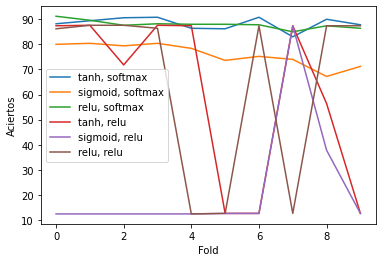

In [ ]:
get_best_activation_function(False)

Before  4500
Y TRAIN [7 7 6 ... 5 4 4]
After  562
X_train (4500, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (4500,) y_test (500,)
y_train_nn (4500, 8) y_test_nn (500, 8)
The batch and the epoch are   32 ,  8
Epoch 1/8
141/140 [==============================] - 2s 15ms/step - loss: 1.9652 - accuracy: 0.1858
Epoch 2/8
141/140 [==============================] - 2s 15ms/step - loss: 1.4495 - accuracy: 0.3631
Epoch 3/8
141/140 [==============================] - 2s 15ms/step - loss: 1.2473 - accuracy: 0.4329
Epoch 4/8
141/140 [==============================] - 2s 15ms/step - loss: 1.1539 - accuracy: 0.4891
Epoch 5/8
141/140 [==============================] - 2s 15ms/step - loss: 1.0958 - accuracy: 0.5173
Epoch 6/8
141/140 [==============================] - 2s 15ms/step - loss: 1.0998 - accuracy: 0.5091
Epoch 7/8
141/140 [==============================] - 2s 15ms/step - loss: 1.0726 - accuracy: 0.5196
Epoch 8/8
141/140 [==============================] - 2s 15ms/step - loss: 1.0647 - accuracy:

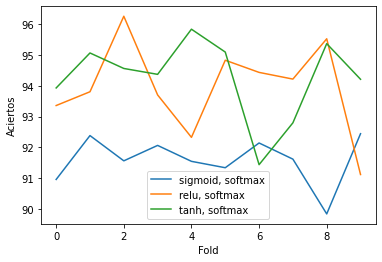

In [ ]:
get_best_activation_function(True)

The new size is  8 ,  32
Before  4500
Y TRAIN [7 7 6 ... 5 4 4]
After  562
X_train (4500, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (4500,) y_test (500,)
y_train_nn (4500, 8) y_test_nn (500, 8)
The batch and the epoch are   32 ,  8
Epoch 1/8
141/140 [==============================] - 2s 15ms/step - loss: 1.3764 - accuracy: 0.3962
Epoch 2/8
141/140 [==============================] - 2s 15ms/step - loss: 1.0568 - accuracy: 0.5478
Epoch 3/8
141/140 [==============================] - 2s 15ms/step - loss: 1.0071 - accuracy: 0.5787
Epoch 4/8
141/140 [==============================] - 2s 15ms/step - loss: 0.9307 - accuracy: 0.6184
Epoch 5/8
141/140 [==============================] - 2s 15ms/step - loss: 0.9365 - accuracy: 0.6082
Epoch 6/8
141/140 [==============================] - 2s 15ms/step - loss: 0.9189 - accuracy: 0.6104
Epoch 7/8
141/140 [==============================] - 2s 15ms/step - loss: 0.8693 - accuracy: 0.6464
Epoch 8/8
141/140 [==============================] - 2s 15ms/step -

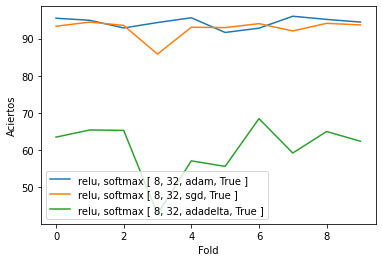

In [ ]:
get_best_optimizer(True)

This section is introductory to serve as a simple example. To test the model created in different situations, a 10 cross validation (10-CV) strategy should be used. 

The new size is  5 ,  32
Before  4500
Y TRAIN [7 7 6 ... 5 4 4]
After  562
X_train (4500, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (4500,) y_test (500,)
y_train_nn (4500, 8) y_test_nn (500, 8)
The batch and the epoch are   32 ,  5
Epoch 1/5
141/140 [==============================] - 2s 16ms/step - loss: 1.2635 - accuracy: 0.4660
Epoch 2/5
141/140 [==============================] - 2s 15ms/step - loss: 0.9703 - accuracy: 0.6027
Epoch 3/5
141/140 [==============================] - 2s 15ms/step - loss: 0.8888 - accuracy: 0.6376
Epoch 4/5
141/140 [==============================] - 2s 15ms/step - loss: 0.9113 - accuracy: 0.6371
Epoch 5/5
141/140 [==============================] - 2s 15ms/step - loss: 0.8524 - accuracy: 0.6544
Predictions Counter({3: 123, 4: 103, 7: 70, 6: 57, 5: 51, 2: 48, 0: 31, 1: 17}) 

Confusion matrix
[[21  0  2 32  0  8  0  0]
 [ 0 15  6  1 38  3  0  0]
 [ 5  1 35 11  7  3  0  0]
 [ 3  0  2 57  0  0  0  0]
 [ 0  0  0  1 54  5  3  0]
 [ 2  1  3 21  3 32  0  0]
 [ 0  

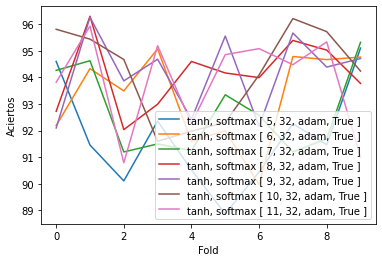

In [20]:
get_best_epoch(True, 'adam')

In [15]:
datagen = ImageDataGenerator(
  rotation_range=20,
  width_shift_range=0.5,
  height_shift_range=0.5,
  horizontal_flip=True)

In [16]:
def get_score(X_train, X_test, y_test, y_train_nn, y_test_nn, activation_function, optimizer , data_augmentation, batch_size , epochs, auc_per_fold, auc_percent_per_fold):
  

  print("The batch and the epoch are  ", batch_size, ", " , epochs)
  
  model = cnn_model(activation_function)
  
  model.compile(loss='categorical_crossentropy',optimizer=optimizer, metrics=['accuracy'])
  
  if data_augmentation == True:  
    datagen.fit(X_train)
    model.fit(datagen.flow(X_train, y_train_nn, batch_size=batch_size), steps_per_epoch=len(X_train) / batch_size, epochs=epochs)
  else: 
  
    early_stopping = EarlyStopping(monitor='val_loss', patience = 10)
    model.fit(X_train, y_train_nn , batch_size=batch_size ,validation_split = 0.1, verbose=2, callbacks=[early_stopping] )
  
  #model.fit(datagen.flow(X_train, y_train_nn, batch_size=batch_size), steps_per_epoch=len(X_train) / batch_size, epochs=epochs) #, callbacks=[early_stopping])
  loss, acc = model.evaluate(X_test, y_test_nn,verbose= 0)
  y_scores = model.predict(X_test) # Confidence prediction per class
  y_pred = y_scores.argmax(axis=1) # Select classes with most confidence prediction
  print('Predictions', collections.Counter(y_pred),'\n')

  print('Confusion matrix')
  print(metrics.confusion_matrix(y_test,y_pred),'\n')

  target_names = ['TUMOR', 'HEALTHY'] if nb_classes ==  2 else ['TUMOR','STROMA','COMPLEX','LYMPHO','DEBRIS','MUCOSA','ADIPOSE','EMPTY']

  print(metrics.classification_report(y_test, y_pred, target_names=target_names))
  if nb_classes ==  2:
    auc_per_fold.append(metrics.roc_auc_score(y_test, np.round(y_scores[:,1],2)))
    auc_percent_per_fold.append(metrics.roc_auc_score(y_test, np.round(y_scores[:,1],2))*100)
    print(f'AUC {metrics.roc_auc_score(y_test, np.round(y_scores[:,1],2)):.4f} ')
  else:
    auc_per_fold.append(metrics.roc_auc_score(y_test, y_scores, multi_class = "ovr"))
    auc_percent_per_fold.append(metrics.roc_auc_score(y_test, y_scores, multi_class = "ovr")*100)
    print(f'AUC {metrics.roc_auc_score(y_test, y_scores, multi_class = "ovr"):.4f} ')
 
  
  
  return loss, acc, auc_per_fold, auc_percent_per_fold, model

In [17]:
def balance_X_train(X_train, y_train): 
  X_train_0 = X_train[y_train[y_train == 0]].view()
 

  y_train_0 = y_train[y_train == 0].view()
  print("Getting the len of the arrays " , len(X_train_0) , " " , len(y_train_0))
  #print(y_train_0)
  size_to_add =X_train.shape[0]- 2*X_train_0.shape[0]
  print("The old size was " ,X_train_0.shape[0] )
  #Setting the x_train and the y_train to the balancing size
  #if size_to_add > 0:     
  for i in range(6):
    
    
    print("The shape is " ,X_train.shape)
    print(y_train)
    
    y_train = np.concatenate([ y_train_0 ,   y_train], axis= 0)
    X_train = np.concatenate([  X_train_0 , X_train] , axis =0) 
    if len(y_train[y_train==0]) > size_to_add:
      break
    
    
    
  print("The new size is " , X_train[y_train[y_train== 0]].shape[0])
  return X_train,y_train

In [18]:
full_test_X = []
full_test_Y = []

def cross_validation( k , activation_function , optimizer, data_augmentation ,batch_size_new, epochs_new):
  batch_size = batch_size_new
  epochs = epochs_new
  auc_per_fold = []
  auc_percent_per_fold = []
  acc_per_fold = []
  acc_percent_per_fold = []
  loss_per_fold = []
  kf = StratifiedKFold(n_splits=k )
  for train_index, test_index in kf.split(X,y): 
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    full_test_X.append(X_test)
    full_test_Y.append( y_test)
    print("Before " ,  X_train.shape[0])
    #Balancing the dataset if it's necessary (Solo cuando es 0 y 1 )
    if nb_classes ==2:
      X_train, y_train= balance_X_train(X_train , y_train);
    print("Y TRAIN" , y_train)
    print("After " ,  X_train[y_train[y_train == 0]].shape[0])
    # Convert integers to one-hot vector
    y_train_nn = keras.utils.to_categorical(y_train, nb_classes)
    y_test_nn = keras.utils.to_categorical(y_test, nb_classes)
    print(f'X_train {X_train.shape} X_test {X_test.shape}')
    print(f'y_train {y_train.shape} y_test {y_test.shape}')
    print(f'y_train_nn {y_train_nn.shape} y_test_nn {y_test_nn.shape}')
  
    actual_loss, actual_acc, auc_per_fold, auc_percent_per_fold, model= get_score(X_train, X_test, y_test, y_train_nn, y_test_nn , activation_function, optimizer, data_augmentation, batch_size_new, epochs_new , auc_per_fold , auc_percent_per_fold )
    
    print(f'loss: {actual_loss:.2f} acc: {actual_acc:.2f}')
    acc_per_fold.append(actual_acc)
    loss_per_fold.append(actual_loss)
    acc_percent_per_fold.append(actual_acc*100) #For getting the wilcoxon 
    
    
  return acc_per_fold, loss_per_fold, auc_per_fold, acc_percent_per_fold, auc_percent_per_fold, model
  #return X_train_output, X_test_output, y_test_nn_output, y_train_nn_output, y_test_output, y_train_output; 


In [ ]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

acc_per_fold, loss_per_fold, auc_per_fold, acc_percent_per_fold, auc_percent_per_fold, model = cross_validation(10 , ["relu", "relu" , "relu" , "relu", "softmax"] , 'adam' , True ,32 , 10 )
print(acc_per_fold)
print(loss_per_fold)
print("AUC PER FOLD " , auc_per_fold)
print(model.summary())
#loss, acc = get_score(X_train, X_test, y_train_nn, y_test_nn)


Before  4500
Y TRAIN [7 7 6 ... 5 4 4]
After  562
X_train (4500, 32, 32, 3) X_test (500, 32, 32, 3)
y_train (4500,) y_test (500,)
y_train_nn (4500, 8) y_test_nn (500, 8)
The batch and the epoch are   32 ,  10
Epoch 1/10
141/140 [==============================] - 2s 15ms/step - loss: 1.4450 - accuracy: 0.3893
Epoch 2/10
141/140 [==============================] - 2s 15ms/step - loss: 1.0186 - accuracy: 0.5593
Epoch 3/10
141/140 [==============================] - 2s 15ms/step - loss: 1.0018 - accuracy: 0.5733
Epoch 4/10
141/140 [==============================] - 2s 15ms/step - loss: 0.9312 - accuracy: 0.6098
Epoch 5/10
141/140 [==============================] - 2s 15ms/step - loss: 0.9065 - accuracy: 0.6251
Epoch 6/10
141/140 [==============================] - 2s 15ms/step - loss: 0.8534 - accuracy: 0.6480
Epoch 7/10
141/140 [==============================] - 2s 15ms/step - loss: 0.8691 - accuracy: 0.6424
Epoch 8/10
141/140 [==============================] - 2s 15ms/step - loss: 0.8168 - 

In [ ]:
def get_graphic_plot():
  plt.plot(range(len( acc_percent_per_fold)) , acc_percent_per_fold , 'ro-',label='acc_x')
  plt.ylabel('Aciertos')
  plt.xlabel('Prueba')
  plt.legend()

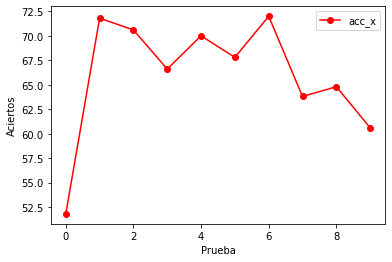

In [ ]:
get_graphic_plot()

#WILCOXON

In [ ]:
def wilcoxon(x,y):
  wilcox_V, p_value =  wilcoxon(x, y, alternative='greater', zero_method='wilcox', correction=False)
  print('Resultado completo del test de Wilcoxon')
  print(f'Wilcox V: {wilcox_V}, p-value: {p_value:.2f}')
  return x, y

### Model and optimizers

Test [optimizer](https://keras.io/optimizers/) parameter with `sgd`, `adadelta` or `adam` values in order to check the final precision achieved.

In [ ]:
print(f'loss: {loss:.2f} acc: {acc:.2f}')

NameError: ignored

In [ ]:
print(model.summary())

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, None, None, 6)     456       
_________________________________________________________________
activation_45 (Activation)   (None, None, None, 6)     0         
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, None, None, 6)     0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, None, None, 16)    2416      
_________________________________________________________________
activation_46 (Activation)   (None, None, None, 16)    0         
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, None, None, 16)    0         
_________________________________________________________________
flatten_9 (Flatten)          (None, None)             

## Prediction

### Testing AUC result for two and multiple classes

In [ ]:
for i in range(len(full_test_X)):

  y_scores = model.predict(full_test_X[i]) # Confidence prediction per class
  y_pred = y_scores.argmax(axis=1) # Select classes with most confidence prediction

  if nb_classes ==  2:
    print(f'AUC {metrics.roc_auc_score(full_test_Y[i], np.round(y_scores[:,1],2)):.4f} ')
  else:
    print(f'AUC {metrics.roc_auc_score(full_test_Y[i], y_scores, multi_class = "ovr"):.4f} ')

AUC 0.9440 
AUC 0.9510 
AUC 0.9473 
AUC 0.9459 
AUC 0.9440 
AUC 0.9449 
AUC 0.9467 
AUC 0.9506 
AUC 0.9474 
AUC 0.9485 


## More metrics about results

We can find more information about `precision`, `recall` and `f1` metrics in <https://en.wikipedia.org/wiki/Precision_and_recall>.

In [ ]:
for i in range(len(full_test_X)):
  y_scores = model.predict(full_test_X[i]) # Confidence prediction per class
  y_pred = y_scores.argmax(axis=1) # Select classes with most confidence prediction

  if nb_classes ==  2:
    print(f'AUC {metrics.roc_auc_score(full_test_Y[i], np.round(y_scores[:,1],2)):.4f} ')
  else:
    print(f'AUC {metrics.roc_auc_score(full_test_Y[i], y_scores, multi_class = "ovr"):.4f} ')
  print('Predictions', collections.Counter(y_pred),'\n')

  print('Confusion matrix')
  print(metrics.confusion_matrix(full_test_Y[i],y_pred),'\n')

  target_names = ['TUMOR', 'HEALTHY'] if nb_classes ==  2 else ['TUMOR','STROMA','COMPLEX','LYMPHO','DEBRIS','MUCOSA','ADIPOSE','EMPTY']

  print(metrics.classification_report(full_test_Y[i], y_pred, target_names=target_names))

AUC 0.9440 
Predictions Counter({3: 118, 5: 82, 7: 77, 2: 72, 6: 50, 4: 39, 1: 35, 0: 27}) 

Confusion matrix
[[22  0  2 31  0  8  0  0]
 [ 0 16 27  0  9 11  0  0]
 [ 1  1 33 15  2 10  0  0]
 [ 2  0  3 57  0  0  0  0]
 [ 0 18  6  0 25 11  3  0]
 [ 2  0  1 15  2 42  0  0]
 [ 0  0  0  0  1  0 47 14]
 [ 0  0  0  0  0  0  0 63]] 

              precision    recall  f1-score   support

       TUMOR       0.81      0.35      0.49        63
      STROMA       0.46      0.25      0.33        63
     COMPLEX       0.46      0.53      0.49        62
      LYMPHO       0.48      0.92      0.63        62
      DEBRIS       0.64      0.40      0.49        63
      MUCOSA       0.51      0.68      0.58        62
     ADIPOSE       0.94      0.76      0.84        62
       EMPTY       0.82      1.00      0.90        63

    accuracy                           0.61       500
   macro avg       0.64      0.61      0.59       500
weighted avg       0.64      0.61      0.59       500

AUC 0.9510 
Predicti